## Scraping Challenge

Do a little scraping or API-calling of your own.  Pick a new website and see what you can get out of it.  Expect that you'll run into bugs and blind alleys, and rely on your mentor to help you get through.  

Formally, your goal is to write a scraper that will:

1) Return specific pieces of information (rather than just downloading a whole page)  
2) Iterate over multiple pages/queries  
3) Save the data to your computer  

Once you have your data, compute some statistical summaries and/or visualizations that give you some new insights into your scraping topic of interest.  Write up a report from scraping code to summary and share it with your mentor.

### Objective

We will scrap Craiglist's Buenos Aires website for housing rent prices in the Palermo area.

In [1]:
# Importing in each cell because of the kernel restarts.
import scrapy
from scrapy.crawler import CrawlerProcess


class CLSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "CL"
    
    # URL(s) to start with.
    allowed_domains = ["buenosaires.craigslist.org"]
    start_urls = [
        'https://buenosaires.craigslist.org/search/hhh?lang=en&cc=us&query=palermo&availabilityMode=0&sale_date=all+dates',
    ]

    # Use XPath to parse the response we get.
    def parse(self, response):
        
        # Iterate over every <article> element on the page.
        for posting in response.xpath('//p'):
            
            # Yield a dictionary with the values we want.
            yield {
                # This is the code to choose what we want to extract
                # You can modify this with other Xpath expressions to extract other information from the site
                'title': posting.xpath('a[@class="result-title hdrlnk"]/text()').extract_first(),
                'date': posting.xpath('time[@class="result-date"]/text()').extract_first(),
                'price': posting.xpath('span/span[@class="result-price"]/text()').extract_first()
            }
        
        # scrape all pages
        next_page_relative_url = response.xpath('//a[@class="button next"]/@href').extract_first()
        next_page_absolute_url = response.urljoin(next_page_relative_url)
        

# Tell the script how to run the crawler by passing in settings.
process = CrawlerProcess({
    'FEED_FORMAT': 'json',         # Store data in JSON format.
    'FEED_URI': 'clbsas.json',  # Name our storage file.
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'ThinkfulDataScienceBootcamp_Rodolfo (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False           # Turn off logging for now.
})

# Start the crawler with our spider.
process.crawl(CLSpider)
process.start()
print('Success!')

Success!


Now we will create a dataframe to analyze the data:

In [2]:
import pandas as pd

# Turning JSON into Data Frame
palermo = pd.read_json('clbsas.json')
print(palermo.shape)
palermo.head()

(120, 3)


,date,price,title
0,Jul 26,₱500,PRIVATE ROOM PALERMO + ALL MEALS AND DRINKS + ...
1,Jul 26,₱545,"PALERMO SOHO---GREAT BEDROOMS--- , MUST SEE! *..."
2,Jul 26,₱950,Beautiful 3br apartment with terrace located i...
3,Jul 26,₱25000,2br apartment Alto Palermo Mall Area
4,Jul 26,₱24500,2br apartment with 2 balconies Palermo University


Somehow I can't make it work for as to scrap all the pages.
We will clean out the peso signs from the price.

In [3]:
import re

palermo.price = palermo.price.map(lambda x: None if x == None else int(re.sub('\₱', '', str(x))))
palermo.head()

,date,price,title
0,Jul 26,500.0,PRIVATE ROOM PALERMO + ALL MEALS AND DRINKS + ...
1,Jul 26,545.0,"PALERMO SOHO---GREAT BEDROOMS--- , MUST SEE! *..."
2,Jul 26,950.0,Beautiful 3br apartment with terrace located i...
3,Jul 26,25000.0,2br apartment Alto Palermo Mall Area
4,Jul 26,24500.0,2br apartment with 2 balconies Palermo University


### Currency exchange function

We will define a function to change the original prices in Argentine Pesos to US Dollars.

In [4]:
currency_exchange = 27.5 # USD 1 = ARS 27.5

In [5]:
def c_e(price_ars):
    price_usd = price_ars/currency_exchange
    return price_usd

palermo['price'] = palermo['price'].apply(c_e)

In [6]:
palermo.head()

,date,price,title
0,Jul 26,18.181818,PRIVATE ROOM PALERMO + ALL MEALS AND DRINKS + ...
1,Jul 26,19.818182,"PALERMO SOHO---GREAT BEDROOMS--- , MUST SEE! *..."
2,Jul 26,34.545455,Beautiful 3br apartment with terrace located i...
3,Jul 26,909.090909,2br apartment Alto Palermo Mall Area
4,Jul 26,890.909091,2br apartment with 2 balconies Palermo University


In [7]:
palermo_price = palermo[palermo.price>0]
average_price = palermo_price.price.mean()

print(average_price)

170.2434514637903


The average price for a space in palermo is of $170.

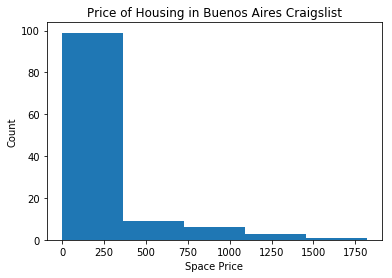

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(palermo_price.price, bins=5)
plt.xlabel('Space Price')
plt.ylabel('Count')
plt.title('Price of Housing in Buenos Aires Craigslist')
plt.show()

We can see that most housing opportunities are under $375, and a few of them over this price.